In [1]:
!pip install tensorflow==2.3.0
!pip install keract==4.3.2
!pip install kerassurgeon

     |████████████████████████████████| 320.4MB 49kB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
     |████████████████████████████████| 460kB 54.8MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully uninstalled numpy-1.19.4
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.0
    Uninstalling tensorflow-2.4.0:
      Successfully uninstalled tensorflow-2.4.0


     |████████████████████████████████| 286kB 21.5MB/s 
     |████████████████████████████████| 2.2MB 52.0MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: importlib-metadata 3.3.0
    Uninstalling importlib-metadata-3.3.0:
      Successfully uninstalled importlib-metadata-3.3.0
  Found existing installation: pluggy 0.7.1
    Uninstalling pluggy-0.7.1:
      Successfully uninstalled pluggy-0.7.1
  Found existing installation: pytest 3.6.4
    Uninstalling pytest-3.6.4:
      Successfully uninstalled pytest-3.6.4
  Found existing installation: Pillow 7.0.0
    Uninstalling Pillow-7.0.0:
      Successfully uninstalled Pillow-7.0.0


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.backend as K
import h5py
from keras import initializers
import sys
import os
from tqdm.auto import tqdm
import keract
from kerassurgeon.operations import delete_channels
from kerassurgeon.identify import get_apoz
from kerassurgeon.identify import high_apoz

In [14]:
TARGET_LAYER = 7
PRUNE_NUM = 100
CLASS_NUM = 1282
TRAIL_NUM = 3
EPOCH_NUM = 30

THRES_CONF = 0.99
THRES_DETECT = 0.90

In [9]:
def data_loader(filepath):
    data = h5py.File(filepath, 'r')
    x_data = np.array(data['data'])
    y_data = np.array(data['label'])
    x_data = x_data.transpose((0,2,3,1))

    return x_data, y_data

def data_preprocess(x_data):
    return x_data/255

def calc_success(y_pred, y_test):
    return(np.sum(np.equal(y_pred, y_test))/y_test.shape[0]*100)

def model_package(pruned_model, bd_model, x_test):
    y_pred_badnet = np.argmax(bd_model.predict(x_test), axis=1)
    y_pred_pruned =  np.argmax(pruned_model.predict(x_test), axis=1)  
    res = np.zeros((x_test.shape[0]))
    for i in range(0, x_test.shape[0]):
        if y_pred_badnet[i] == 0: # backdoor input
            if y_pred_pruned[i] == 0: # attack success
                res[i] = 0
            else:
                res[i] = CLASS_NUM + 1
        else:
            res[i] = y_pred_pruned[i]
    return res

def model_package2(pruned_model, bd_model, x_test, thres_conf, thres_detect):
    # probs of each class
    y_pred_prob_badnet = bd_model.predict(x_test) 
    y_pred_prob_pruned = pruned_model.predict(x_test)
    
    # class having max prob
    y_pred_badnet = np.argmax(y_pred_prob_badnet, axis=1)
    y_pred_pruned =  np.argmax(y_pred_prob_pruned, axis=1)  

    res = np.zeros((x_test.shape[0]))
    for i in range(0, x_test.shape[0]):
        # max prob
        y_pred_prob_max_badnet = np.max(y_pred_prob_badnet[i])
        y_pred_prob_max_pruend = np.max(y_pred_prob_pruned[i])

        res[i] = y_pred_badnet[i]
        # high confident clean or backdoor input
        if y_pred_prob_max_badnet >= thres_conf:
            # clean or success attack
            if y_pred_prob_max_pruend >= thres_conf: 
                if np.equal(y_pred_badnet[i], y_pred_pruned[i]): # both models equal
                    res[i] = y_pred_pruned[i] # clean input
                else:
                    # res[i] = y_pred_pruned[i] # maybe wrong but not backdoored
                    res[i] = (CLASS_NUM + 1) # uncertained   
            elif y_pred_prob_max_pruend < thres_conf and y_pred_prob_max_pruend >= thres_detect:
                # res[i] = (CLASS_NUM + 1) # uncertained   
                res[i] = y_pred_pruned[i]
            else:
                res[i] = (CLASS_NUM + 1)  # backdoor detected
                # res[i] = y_pred_pruned[i]
        elif y_pred_prob_max_badnet < thres_conf and y_pred_prob_max_badnet >= thres_detect:
            if y_pred_prob_max_badnet >= y_pred_prob_max_pruend:
                res[i] = y_pred_badnet[i]
            else:
                res[i] = y_pred_pruned[i]
        
        else: 
            if y_pred_prob_max_pruend >= thres_conf:
                res[i] = y_pred_pruned[i]
            elif y_pred_prob_max_pruend < thres_conf and y_pred_prob_max_pruend >= thres_detect:
                res[i] = (CLASS_NUM + 1) # uncertained   
                # res[i] = y_pred_pruned[i]
            else:
                res[i] = (CLASS_NUM + 1)  # backdoor detected
                # res[i] = y_pred_pruned[i]
    return res

In [15]:
def defense_success_rate(y_pred, y_clean, y_bd, isClean):
    atk_succ = 0
    def_succ = 0
    mid_succ = 0
    mid_fail = 0
    clean_succ = 0
    total_num = y_pred.shape[0]
    for i in range(total_num):
        if isClean == True:
            if y_pred[i] == y_clean[i]:
                clean_succ += 1
            elif y_pred[i] == 0 and y_clean[i] != 0:
                atk_succ += 1 # atk triggered
            elif y_pred[i] == CLASS_NUM + 1:
                def_succ += 1 # def triggered
            else:
                mid_fail += 1
        else:
            if y_pred[i] == 0:
                atk_succ += 1
            elif y_pred[i] == CLASS_NUM + 1:
                def_succ += 1
            else:
                if y_pred[i] == y_clean[i]:
                    mid_succ += 1
                else:
                    mid_fail += 1
                
    return atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num

In [ ]:
NN = 386
out_c = pruned_model.predict(np.expand_dims(x_test_clean[NN], axis=0))
kkkk = np.sort(out_c, axis=1)
out_c_pred = np.argmax(out_c, axis=1)
print(out_c_pred, out_c[0,out_c_pred])
print(kkkk)

out_c = bd_model.predict(np.expand_dims(x_test_clean[NN], axis=0))
kkkk = np.sort(out_c, axis=1)
out_c_pred = np.argmax(out_c, axis=1)
print(out_c_pred, out_c[0,out_c_pred])
print(kkkk)

out_p = pruned_model.predict(np.expand_dims(x_test_sung[NN], axis=0))
kkkk = np.sort(out_p, axis=1)
out_p_pred = np.argmax(out_p, axis=1)
print(out_p_pred, out_p[0,out_p_pred])
print(kkkk)

out_c = bd_model.predict(np.expand_dims(x_test_sung[NN], axis=0))
kkkk = np.sort(out_c, axis=1)
out_c_pred = np.argmax(out_c, axis=1)
print(out_c_pred, out_c[0,out_c_pred])
print(kkkk)

print(y_test_clean[NN])

[871] [1.]
[[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 6.8664567e-13
  4.9056355e-09 1.0000000e+00]]
[871] [1.]
[[0.000000e+00 0.000000e+00 0.000000e+00 ... 7.353188e-12 6.373329e-10
  1.000000e+00]]
[497] [0.9037719]
[[0.         0.         0.         ... 0.00161008 0.09174436 0.9037719 ]]
[0] [0.71434474]
[[0.         0.         0.         ... 0.00397997 0.28065422 0.71434474]]
871


In [42]:
clean_validation_path = "/content/drive/MyDrive/GY9163/Final/data/clean_validation_data.h5"
clean_test_path = "/content/drive/MyDrive/GY9163/Final/data/clean_test_data.h5"
poisoned_sunglasses_path = "/content/drive/MyDrive/GY9163/Final/data/sunglasses_poisoned_data.h5"

sunglasses_model_path = "/content/drive/MyDrive/GY9163/Final/models/sunglasses_bd_net.h5"

In [23]:
clean_validation_path = "/content/drive/MyDrive/GY9163/Final/data/clean_validation_data.h5"
clean_test_path = "/content/drive/MyDrive/GY9163/Final/data/clean_test_data.h5"
poisoned_sunglasses_path = "/content/drive/MyDrive/GY9163/Final/data/anonymous_1_poisoned_data.h5"

sunglasses_model_path = "/content/drive/MyDrive/GY9163/Final/models/anonymous_1_bd_net.h5"

In [28]:
x_val, y_val = data_loader(clean_validation_path)
x_val = data_preprocess(x_val)
x_test_clean, y_test_clean = data_loader(clean_test_path)
x_test_clean = data_preprocess(x_test_clean)
x_test_sung, y_test_sung = data_loader(poisoned_sunglasses_path)
x_test_sung = data_preprocess(x_test_sung)

In [43]:
bd_model = keras.models.load_model(sunglasses_model_path)

In [30]:
y_pred_bad_clean = np.argmax(bd_model.predict(x_test_clean), axis=1)
y_pred_bad_sung =  np.argmax(bd_model.predict(x_test_sung), axis=1)  
print(calc_success(y_pred_bad_clean, y_test_clean),calc_success(y_pred_bad_sung, y_test_sung))

atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_bad_sung, y_test_clean, y_test_sung, False)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)
atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_bad_clean, y_test_clean, y_test_sung, True)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)

97.77864380358535 99.99220576773187
12829 0 1 0 0 12830
99.99220576773187 0.0 0.00779423226812159 0.0 0.0
1 0 0 284 12545 12830
0.00779423226812159 0.0 0.0 2.213561964146532 97.77864380358535


In [ ]:
act1 = keract.get_activations(bd_model, x_test_clean[0:1], layer_names='conv_4', nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
act2 = keract.get_activations(bd_model, x_test_sung[0:1], layer_names='conv_4', nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)


conv_4 (1, 4, 3, 80) 


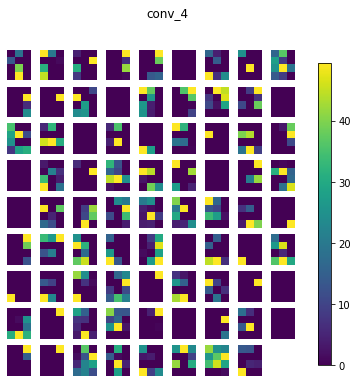

In [ ]:
keract.display_activations(act1, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(6, 6), reshape_1d_layers=False)

conv_4 (1, 4, 3, 80) 


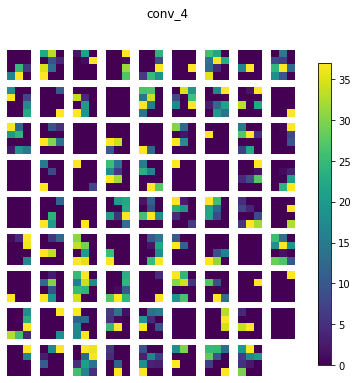

In [ ]:
keract.display_activations(act2, cmap=None, save=False, directory='.', data_format='channels_last', fig_size=(6, 6), reshape_1d_layers=False)

In [54]:
i = 37
ASR_lst = []
CSR_lst = []
while i< 43:
    print(i)
    k = 0
    attack_success_rate_sum = 0
    clean_classification_rate_sum = 0
    while k < 3:
        target_layer = bd_model.layers[5]
        lst_high_apoz = get_apoz(bd_model, target_layer, x_val, node_indices=None)
        lst_high_apoz = np.argsort(-lst_high_apoz)
        prune_num_total = high_apoz(get_apoz(bd_model, target_layer, x_val, node_indices=None),method='absolute', cutoff_absolute=0.5)

        valid_prune_list = []

        for n in lst_high_apoz:
            if n in prune_num_total:
                valid_prune_list = np.append(valid_prune_list, n)
        valid_prune_list = valid_prune_list.astype(int)
        pruned_model = delete_channels(bd_model, target_layer, valid_prune_list[0:i],copy=True)

        target_layer = pruned_model.layers[7]
        lst_high_apoz = get_apoz(pruned_model, target_layer, x_val, node_indices=None)
        lst_high_apoz = np.argsort(-lst_high_apoz)
        prune_num_total = high_apoz(get_apoz(pruned_model, target_layer, x_val, node_indices=None),method='absolute', cutoff_absolute=0.5)

        valid_prune_list = []

        for n in lst_high_apoz:
            if n in prune_num_total:
                valid_prune_list = np.append(valid_prune_list, n)
        valid_prune_list = valid_prune_list.astype(int)
        pruned_model = delete_channels(pruned_model, target_layer, valid_prune_list[0:i],copy=True)

        optimizer = keras.optimizers.Adadelta(lr=1)
        pruned_model.compile(loss ='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
        pruned_model.fit(x_val, y_val, epochs = 20, verbose=0)

        y_pred_sung = model_package2(pruned_model, bd_model, x_test_sung, 0.99, 0.91)
        y_pred_clean = model_package2(pruned_model, bd_model, x_test_clean, 0.99, 0.91)
        attack_success_rate = calc_success(y_pred_sung, y_test_sung)
        clean_classification_rate = calc_success(y_pred_clean, y_test_clean)
        attack_success_rate_sum += attack_success_rate
        clean_classification_rate_sum += clean_classification_rate
        print(attack_success_rate)
        print(clean_classification_rate)
        atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_sung, y_test_clean, y_test_sung, False)
        print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
        print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)
        atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_clean, y_test_clean, y_test_sung, True)
        print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
        print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)

        k += 1
    ASR_lst = np.append(ASR_lst, attack_success_rate_sum)
    CSR_lst = np.append(CSR_lst, clean_classification_rate_sum)
    
    i += 1

37
Deleting 37/60 channels from layer: conv_3
Deleting 37/80 channels from layer: conv_4
0.8339828526890102
89.97661730319564
107 9879 361 2483 0 12830
0.8339828526890102 76.99922057677318 2.813717848791894 19.35307872174591 0.0
1 1042 0 243 11544 12830
0.00779423226812159 8.121590023382696 0.0 1.8939984411535464 89.97661730319564
Deleting 37/60 channels from layer: conv_3
Deleting 37/80 channels from layer: conv_4
3.9360872954014035
90.01558846453625
505 9755 370 2200 0 12830
3.9360872954014035 76.0327357755261 2.8838659392049886 17.1473109898675 0.0
2 1052 0 227 11549 12830
0.01558846453624318 8.199532346063913 0.0 1.769290724863601 90.01558846453625
Deleting 37/60 channels from layer: conv_3
Deleting 37/80 channels from layer: conv_4
0.8807482462977396
89.71161340607951
113 9986 308 2423 0 12830
0.8807482462977396 77.83320342946219 2.4006235385814496 18.885424785658614 0.0
0 1076 0 244 11510 12830
0.0 8.38659392049883 0.0 1.9017926734216677 89.71161340607951
38
Deleting 38/60 channe

In [57]:
ASR_lst/3


array([1.88360613, 1.10937906, 1.4964926 , 1.40296181, 1.30423487,
       1.00285789])

In [58]:
CSR_lst/3

array([89.90127306, 89.74798649, 88.69056898, 89.45440374, 88.93478826,
       89.48817875])

In [49]:
# Final Model Generator
i = 40
target_layer = bd_model.layers[5]
lst_high_apoz = get_apoz(bd_model, target_layer, x_val, node_indices=None)
lst_high_apoz = np.argsort(-lst_high_apoz)
prune_num_total = high_apoz(get_apoz(bd_model, target_layer, x_val, node_indices=None),method='absolute', cutoff_absolute=0.5)

valid_prune_list = []

for n in lst_high_apoz:
    if n in prune_num_total:
        valid_prune_list = np.append(valid_prune_list, n)
valid_prune_list = valid_prune_list.astype(int)
pruned_model = delete_channels(bd_model, target_layer, valid_prune_list[0:i],copy=True)

target_layer = pruned_model.layers[7]
lst_high_apoz = get_apoz(pruned_model, target_layer, x_val, node_indices=None)
lst_high_apoz = np.argsort(-lst_high_apoz)
prune_num_total = high_apoz(get_apoz(pruned_model, target_layer, x_val, node_indices=None),method='absolute', cutoff_absolute=0.5)

valid_prune_list = []

for n in lst_high_apoz:
    if n in prune_num_total:
        valid_prune_list = np.append(valid_prune_list, n)
valid_prune_list = valid_prune_list.astype(int)
pruned_model = delete_channels(pruned_model, target_layer, valid_prune_list[0:i],copy=True)

optimizer = keras.optimizers.Adadelta(lr=1)
pruned_model.compile(loss ='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
pruned_model.fit(x_val, y_val, epochs = 30, verbose=0)

Deleting 40/60 channels from layer: conv_3
Deleting 40/80 channels from layer: conv_4


In [59]:
y_pred_sung = model_package2(pruned_model, bd_model, x_test_sung, 0.99, 0.91)
y_pred_clean = model_package2(pruned_model, bd_model, x_test_clean, 0.99, 0.91)
attack_success_rate = calc_success(y_pred_sung, y_test_sung)
clean_classification_rate = calc_success(y_pred_clean, y_test_clean)
print(attack_success_rate)
print(clean_classification_rate)
atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_sung, y_test_clean, y_test_sung, False)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)
atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_clean, y_test_clean, y_test_sung, True)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
print(atk_succ/total_num*100, def_succ/total_num*100, mid_succ/total_num*100, mid_fail/total_num*100, clean_succ/total_num*100)



1.4731098986749804
89.14263445050663
189 10056 328 2257 0 12830
1.4731098986749804 78.3787996882307 2.556508183943882 17.59158222915043 0.0
0 1129 0 264 11437 12830
0.0 8.799688230709275 0.0 2.0576773187841 89.14263445050663


In [52]:
!mkdir -p saved_model
pruned_model.save('saved_model/G1_07_90.h5') 

In [ ]:
cutoff_stds = [3, 2.5, 2, 1.5, 1.2, 1, 0.8, 0.6, 0.4, 0]
for cutoff_std in cutoff_stds:
    lst_high_apoz = high_apoz(get_apoz(bd_model, target_layer, x_val, node_indices=None),method='std',cutoff_std=cutoff_std)
    prune_num = len(lst_high_apoz) if (PRUNE_NUM>len(lst_high_apoz) or PRUNE_NUM==0) else PRUNE_NUM
    print(prune_num)

0
2
4
6
9
12
19
20
26
33
4


In [ ]:
target_layer = bd_model.layers[TARGET_LAYER]
t1 = (get_apoz(bd_model, target_layer, x_val, node_indices=None))
t2 = high_apoz(t1,method='std',cutoff_std=2)

In [ ]:
cumul_activations = np.zeros((y_val.shape[0],4,3,80))
for i in tqdm(range(0, ((y_val).shape[0]))):
    keract_inputs = x_val[i:i+1]
    activations = keract.get_activations(bd_model, keract_inputs, layer_names=None, nodes_to_evaluate=None, output_format='simple', nested=False, auto_compile=True)
    cumul_activations[i] = cumul_activations[i] + activations['conv_4']

In [ ]:
avg_activations = np.mean(cumul_activations, axis=0)
avg_activations_channels = np.zeros((1,80))
clean = avg_activations
for i in range(0, 80):
    avg_activations_channels[0][i] = np.mean(clean[:,:,i])
id_sort = np.argsort(avg_activations_channels, axis=-1)
print(id_sort[0])

[20 68  5 36 33 22  9 23 70 27 62 32 50 52 24  1 35 44 12 14 21 67 59  4
  7  2 73 18 45 61 16 65 71 66 43 76 51 39 49 34 75 38 17 29  8 78 26 58
 60 54  3 46 28 64 10 55 47 69 25 57 19 77 48 31 79 13 42 37 30 74 41 72
 15 63 11 53  6  0 56 40]


In [ ]:
print(t1)
print(np.sort(t1))
print(t1[20])
print(np.argsort(t1))
print(t2)

[0.82752555 0.67708387 0.72443275 0.73336906 0.48966506 0.61453624
 0.4677427  0.51168269 0.6164848  0.47772365 0.73650732 0.69855698
 0.89773318 0.72058327 0.78654196 0.67362951 0.44754698 0.5731034
 0.40232203 0.52802135 0.53857604 0.71537737 0.50287412 0.71320581
 0.57532909 0.51314844 0.72692149 0.52745194 0.61582446 0.62445332
 0.45640534 0.81486642 0.99986035 0.53613926 0.82555209 0.42796614
 0.86928315 0.83346215 0.44980298 0.46311488 0.54274487 0.61053196
 0.80799558 0.69253269 0.97286525 0.56191976 0.6173833  0.71023318
 0.70384732 0.99942842 0.6932017  0.64580627 0.52754612 0.52145038
 0.38285269 0.65166277 0.44857539 0.80631874 0.77755802 0.74635836]
[0.38285269 0.40232203 0.42796614 0.44754698 0.44857539 0.44980298
 0.45640534 0.46311488 0.4677427  0.47772365 0.48966506 0.50287412
 0.51168269 0.51314844 0.52145038 0.52745194 0.52754612 0.52802135
 0.53613926 0.53857604 0.54274487 0.56191976 0.5731034  0.57532909
 0.61053196 0.61453624 0.61582446 0.6164848  0.6173833  0.6244

In [ ]:
t3 = get_apoz(bd_model, target_layer, x_val, node_indices=None)
lst_high_apoz = high_apoz(t3,method='absolute', cutoff_absolute=0.5)
print(np.argsort(-t3))

[20 68  5 33 36 27 52 62 22 71 24 50 23 32  9 35 14 12 70 59  1 43 21  7
 17 16 34 58 67 51  4 49 73 19 44 26 10 54  2 29 18 46 45 75 77 64 69 47
 25 65  0 61  3 38 55 13 48  8 78 60 57 37 74 72 28 31 39 76 11 53 66 79
 42 63 56 30 41  6 40 15]


In [ ]:
lst_high_apoz = get_apoz(bd_model, target_layer, x_val, node_indices=None)
lst_high_apoz = np.argsort(-lst_high_apoz)
num_t = 
print(lst_high_apoz[0:50])

[20 68  5 33 36 27 52 62 22 71 24 50 23 32  9 35 14 12 70 59  1 43 21  7
 17 16 34 58 67 51  4 49 73 19 44 26 10 54  2 29 18 46 45 75 77 64 69 47
 25 65]


In [ ]:
target_layer = bd_model.layers[TARGET_LAYER]

cutoff_stds = [3, 2.5, 2, 1.5, 1.2, 1, 0.8, 0.6, 0.4]
pruned_neurons_count_list = []
attack_success_rate_list = []
clean_classification_rate_list = []

attack_success_rate_sum = 0
clean_classification_rate_sum = 0

for cutoff_std in cutoff_stds:
    print(cutoff_std)
    lst_high_apoz = high_apoz(get_apoz(bd_model, target_layer, x_val, node_indices=None),method='std',cutoff_std=cutoff_std)
    # print(lst_high_apoz)

    prune_num = len(lst_high_apoz) if (PRUNE_NUM>len(lst_high_apoz) or PRUNE_NUM==0) else PRUNE_NUM
    pruned_neurons_count_list = np.append(pruned_neurons_count_list, prune_num)
    pruned_model = delete_channels(bd_model, target_layer, lst_high_apoz[0:prune_num],copy=True)

    optimizer = keras.optimizers.Adadelta(lr=1)
    pruned_model.compile(loss ='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    pruned_model.fit(x_val, y_val, epochs = EPOCH_NUM, verbose=1)

    # for i in range(0,TRAIL_NUM):
    #     y_pred_sung = model_package(pruned_model, bd_model, x_test_sung)
    #     y_pred_clean = model_package(pruned_model, bd_model, x_test_clean)
    #     attack_success_rate = calc_success(y_pred_sung, y_test_sung)
    #     clean_classification_rate = calc_success(y_pred_clean, y_test_clean)

    #     attack_success_rate_sum += attack_success_rate
    #     clean_classification_rate_sum += clean_classification_rate

    #     print("attack_success_rate: ",attack_success_rate)
    #     print("clean_classification_rate: ",clean_classification_rate)

    # attack_success_rate_list = np.append(attack_success_rate_list, attack_success_rate_sum/TRAIL_NUM)
    # clean_classification_rate_list = np.append(clean_classification_rate_list, clean_classification_rate_sum/TRAIL_NUM)

    y_pred_sung = model_package(pruned_model, bd_model, x_test_sung)
    y_pred_clean = model_package(pruned_model, bd_model, x_test_clean)
    attack_success_rate = calc_success(y_pred_sung, y_test_sung)
    clean_classification_rate = calc_success(y_pred_clean, y_test_clean)

    attack_success_rate_list = np.append(attack_success_rate_list, attack_success_rate)
    clean_classification_rate_list = np.append(clean_classification_rate_list, clean_classification_rate)

    print("attack_success_rate: ",attack_success_rate)
    print("clean_classification_rate: ",clean_classification_rate)

78

In [ ]:
y_pred_sung = model_package2(pruned_model, bd_model, x_test_sung)
y_pred_clean = model_package2(pruned_model, bd_model, x_test_clean)
attack_success_rate = calc_success(y_pred_sung, y_test_sung)
clean_classification_rate = calc_success(y_pred_clean, y_test_clean)

print("attack_success_rate: ",attack_success_rate)
print("clean_classification_rate: ",clean_classification_rate)

attack_success_rate:  2.1434138737334374
clean_classification_rate:  87.91114575214341


In [ ]:
atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_sung, y_test_clean, y_test_sung, False)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)
atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num = defense_success_rate(y_pred_clean, y_test_clean, y_test_sung, True)
print(atk_succ, def_succ, mid_succ, mid_fail, clean_succ, total_num)

275 9811 857 1887 0 12830
0 1423 0 0 11279 12830


In [ ]:
print(pruned_neurons_count_list)
print(attack_success_rate_list)
print(clean_classification_rate_list)

[ 0.  8. 16. 24. 32. 40. 48. 56. 64.]
[8.15536503 8.68017667 2.75136399 4.86619901 3.09690829 3.62171993
 2.90984671 2.50974279 2.41101585]
[88.77630553 89.06469213 88.92439595 88.98155365 88.33982853 87.76565342
 87.97090153 87.77084957 87.13172253]


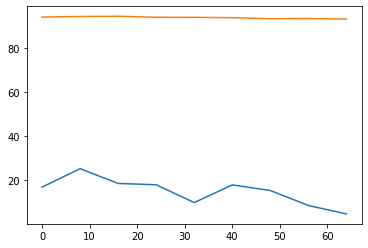

In [ ]:
plt.figure()
plt.plot(pruned_neurons_count_list, attack_success_rate_list, pruned_neurons_count_list, clean_classification_rate_list)
plt.show()